# Acqusition Function Optimization with Genetic Algorithm

As an alternative to gradient-based optimizations, the Genetic Algorithm can be used for optimizing Acqusition functions

In [ ]:
from copy import deepcopy
from time import time

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
from bofire.benchmarks import api as benchmarks
from bofire.data_models.constraints import api as constraints_data_models
from bofire.data_models.strategies import api as strategies_data_models
from bofire.strategies import api as strategies

## The GA supports multiple different constraints
Genetic algorithms are quite flexible and can handle a variety of constraints. However, they usually struggle with equality constraints. In the implementation, linear equality- and inequality constraints, as well as N-choose-k cosntraints are handled by a repair function, using QP. Nonlinear constraints are handled by the GA objective function.

In [ ]:
benchmark = benchmarks.Himmelblau()
# generate experiments
experiments = benchmark.f(benchmark.domain.inputs.sample(10), return_complete=True)

In [ ]:
optimizer = strategies_data_models.GeneticAlgorithmOptimizer(
    population_size=100,
    n_max_gen=100,
    verbose=False,
)

In [ ]:
benchmark_grid = np.hstack(
    [
        x.reshape((-1, 1))
        for x in np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
    ]
)
benchmark_grid = pd.DataFrame(
    benchmark_grid, columns=benchmark.domain.inputs.get_keys()
)
benchmark_grid["y"] = benchmark.f(benchmark_grid)["y"]

In [ ]:
def get_proposals(domain, n: int = 10) -> pd.DataFrame:
    strategy = strategies_data_models.SoboStrategy(
        domain=domain, acquisition_optimizer=optimizer
    )
    # map to strategy object, and train the model
    strategy = strategies.map(strategy)
    strategy.tell(experiments)
    t0 = time()
    proposals = strategy.ask(n)
    print(f"Generated {len(proposals)} experiments, Time taken: {time() - t0:.2f}s")
    return proposals

#### Linear Equality and Inequality Constraints are handled by a repair function, using QP

In [ ]:
# generate different cases
domain = deepcopy(benchmark.domain)
domain.constraints.constraints += [
    constraints_data_models.LinearEqualityConstraint(  # x_1 + x_2 = 3
        features=["x_1", "x_2"],
        coefficients=[1, 1],
        rhs=3,
    ),
    constraints_data_models.LinearInequalityConstraint(  # x_2 <= x_1
        features=["x_1", "x_2"],
        coefficients=[-1, 1],
        rhs=0,
    ),
]

In [ ]:
proposals = get_proposals(domain)

/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12

Generated 10 experiments, Time taken: 38.22s


/var/folders/nz/mktm3tp93bb8z4cp_xyjgtzr0000gn/T/ipykernel_27090/43283566.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(benchmark_grid["x_1"].values.reshape((100, 100)), benchmark_grid["x_2"].values.reshape((100, 100)), benchmark_grid["y"].values.reshape((100, 100)), levels=20, label="true system response")


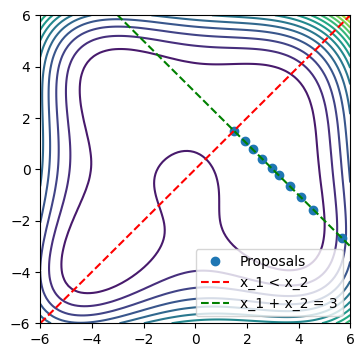

In [ ]:
plt.figure(figsize=(4, 4))
plt.contour(
    benchmark_grid["x_1"].values.reshape((100, 100)),
    benchmark_grid["x_2"].values.reshape((100, 100)),
    benchmark_grid["y"].values.reshape((100, 100)),
    levels=20,
    label="true system response",
)
plt.plot(proposals["x_1"], proposals["x_2"], "o", label="Proposals")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.plot((-6, 6), (-6, 6), "r--", label="x_1 < x_2")
plt.plot((-6, 6), (9, -3), "g--", label="x_1 + x_2 = 3")
plt.legend()
plt.show()

#### NChooseK Constraints are also handled by a repair function, using QP

In [ ]:
domain = deepcopy(benchmark.domain)
domain.inputs.get_by_key("x_1").bounds = (0.0, 6.0)
domain.inputs.get_by_key("x_2").bounds = (0.0, 6.0)
domain.constraints.constraints += [
    constraints_data_models.NChooseKConstraint(
        features=["x_1", "x_2"],
        min_count=1,
        max_count=1,
        none_also_valid=True,
    ),
]

In [ ]:
proposals = get_proposals(domain, n=10)

/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/Users/gdiwt/mambaforge/envs/bofire/lib/python3.12/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power(

Generated 10 experiments, Time taken: 9.61s


/var/folders/nz/mktm3tp93bb8z4cp_xyjgtzr0000gn/T/ipykernel_27090/1637011213.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(benchmark_grid["x_1"].values.reshape((100, 100)), benchmark_grid["x_2"].values.reshape((100, 100)), benchmark_grid["y"].values.reshape((100, 100)), levels=20, label="true system response")


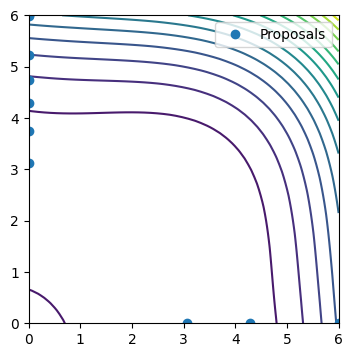

In [ ]:
plt.figure(figsize=(4, 4))
plt.contour(
    benchmark_grid["x_1"].values.reshape((100, 100)),
    benchmark_grid["x_2"].values.reshape((100, 100)),
    benchmark_grid["y"].values.reshape((100, 100)),
    levels=20,
    label="true system response",
)
plt.plot(proposals["x_1"], proposals["x_2"], "o", label="Proposals")
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.legend()
plt.show()

#### Inequality Constraints are handled by the GA objctive function

In [ ]:
domain = deepcopy(benchmark.domain)
domain.constraints.constraints += [
    constraints_data_models.NonlinearInequalityConstraint(
        expression="x_1**2 + x_2**2 - 16",
        features=["x_1", "x_2"],
    ),
]
proposals = get_proposals(domain, n=20)

Generated 20 experiments, Time taken: 7.21s


/var/folders/nz/mktm3tp93bb8z4cp_xyjgtzr0000gn/T/ipykernel_27090/3344335141.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(benchmark_grid["x_1"].values.reshape((100, 100)), benchmark_grid["x_2"].values.reshape((100, 100)), benchmark_grid["y"].values.reshape((100, 100)), levels=20, label="true system response")


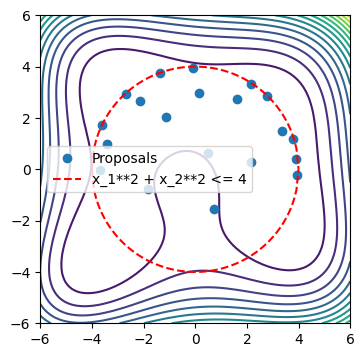

In [ ]:
plt.figure(figsize=(4, 4))
plt.contour(
    benchmark_grid["x_1"].values.reshape((100, 100)),
    benchmark_grid["x_2"].values.reshape((100, 100)),
    benchmark_grid["y"].values.reshape((100, 100)),
    levels=20,
    label="true system response",
)
plt.plot(proposals["x_1"], proposals["x_2"], "o", label="Proposals")
x = np.linspace(-4, 4, 100)
y1 = np.sqrt(16 - x**2)
y2 = -y1
plt.plot(x, y1, "r--", label="x_1**2 + x_2**2 <= 4")
plt.plot(x, y2, "r--")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.legend()
plt.show()